In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os

import nltk
nltk_data_path = "../venv/nltk_data"

import torch
from tqdm import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


In [5]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

e:\dev projects\cine-hype-index\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
file_dir = '../comments/'
movies_list = []
sentiment_scores = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move model to GPU ONCE

for file in sorted(os.listdir(file_dir)):
    movies_list.append(file.removesuffix('.csv'))
    file_path = os.path.join(file_dir, file)
    df = pd.read_csv(file_path)

    weighted_scores = []
    total_weight = 0

    for text, likes in tqdm(zip(df['text'], df['like_count']), total=len(df), desc='Processing comments'):
        encoded_text = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        encoded_text = {k: v.to(device) for k, v in encoded_text.items()}  # Move input to GPU
        
        with torch.no_grad(): 
            output = model(**encoded_text)
        
        scores = output[0][0].cpu().detach().numpy()  # Move back to CPU for numpy
        scores = softmax(scores)

        single_score = float(scores[2] - scores[0])

        # confidence = 1 - scores[1]
        weight = 1 + likes
        weighted_scores.append(single_score * weight)
        total_weight += weight  #total likes

    avg_sentiment = sum(weighted_scores)/total_weight
    avg_sentiment = round(avg_sentiment, 3)
    sentiment_scores.append(avg_sentiment)

print(movies_list)
print(sentiment_scores)



Processing comments: 100%|██████████| 3059/3059 [01:41<00:00, 30.19it/s]

['Alien Romulus', 'Bad Boys 4', 'Borderlands', 'Deadpool 3', 'Dune Part 2', 'Fall guy', 'Gladiator 2', 'Godzilla X Kong', 'Heretic', 'Joker Folie à Deux', 'Kingdom of the Planet of the Apes', 'Kraven the hunter', 'Lisa Frankenstein', 'Madame Web', 'Mean girls', 'Mufasa The lion king', 'Nosferatu', 'Red One', 'Road House', 'Smile 2', 'Sonic the hedgehog 3', 'The Book of Clarence', 'Transformers One', 'Venom 3', 'Wicked']
[-0.103, 0.102, -0.17, 0.388, 0.622, 0.163, -0.07, 0.252, 0.149, 0.178, 0.679, 0.212, 0.901, 0.583, 0.049, 0.111, 0.258, 0.191, 0.26, 0.22, 0.61, -0.135, -0.395, 0.297, 0.203]


In [ ]:
# movie_list = ['Alien Romulus', 'Bad Boys 4', 'Borderlands', 'Deadpool 3', 'Dune Part 2', 'Fall guy', 'Gladiator 2', 'Godzilla X Kong', 'Heretic', 'Joker Folie à Deux', 'Kingdom of the Planet of the Apes', 'Kraven the hunter', 'Lisa Frankenstein', 'Madame Web', 'Mean girls', 'Mufasa The lion king', 'Nosferatu', 'Red One', 'Road House', 'Smile 2', 'Sonic the hedgehog 3', 'The Book of Clarence', 'Transformers One', 'Venom 3', 'Wicked']
# sentiment_scores = [-0.103, 0.102, -0.17, 0.388, 0.622, 0.163, -0.07, 0.252, 0.149, 0.178, 0.679, 0.212, 0.401, 0.583, 0.049, 0.111, 0.258, 0.191, 0.26, 0.22, 0.61, -0.135, -0.395, 0.297, 0.403]

budget_list = [80, 100, 115, 200, 190, 130, 250, 135, 10, 190, 160, 110, 13, 80, 17, 200, 50, 250, 85, 28, 122, 40, 75, 120, 150]
revenue_list = [108, 404, 33, 1338, 705, 181, 462, 572, 59, 207, 397, 62, 9, 100, 130, 722, 181, 186, 150, 138, 492, 8, 69, 478, 350]

#ROI = revenue/budget
returns = [1.35, 4.04, 0.287, 6.69, 3.711, 1.392, 1.848, 4.237, 5.9, 1.089, 2.481, 0.564, 0.692, 1.25, 7.647, 3.61, 3.62, 0.744, 1.765, 4.929, 4.033, 0.2, 0.92, 3.983, 2.33]

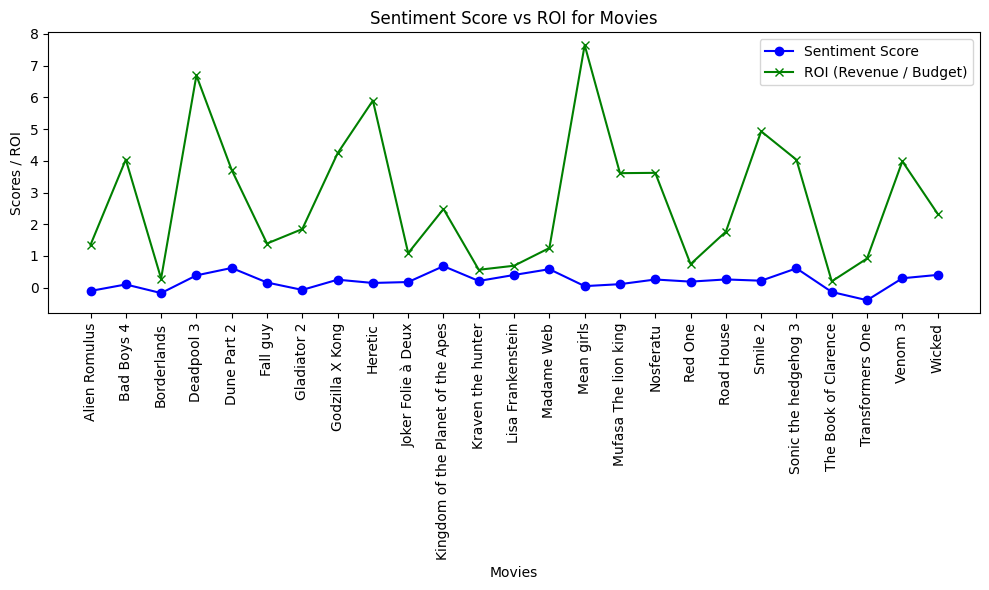

In [54]:
plt.figure(figsize=(10,6))

# Plot sentiment scores
plt.plot(movies_list, sentiment_scores, label='Sentiment Score', color='b', marker='o')

# Plot returns (ROI)
plt.plot(movies_list, returns, label='ROI (Revenue / Budget)', color='g', marker='x')

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Labels and title
plt.xlabel('Movies')
plt.ylabel('Scores / ROI')
plt.title('Sentiment Score vs ROI for Movies')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

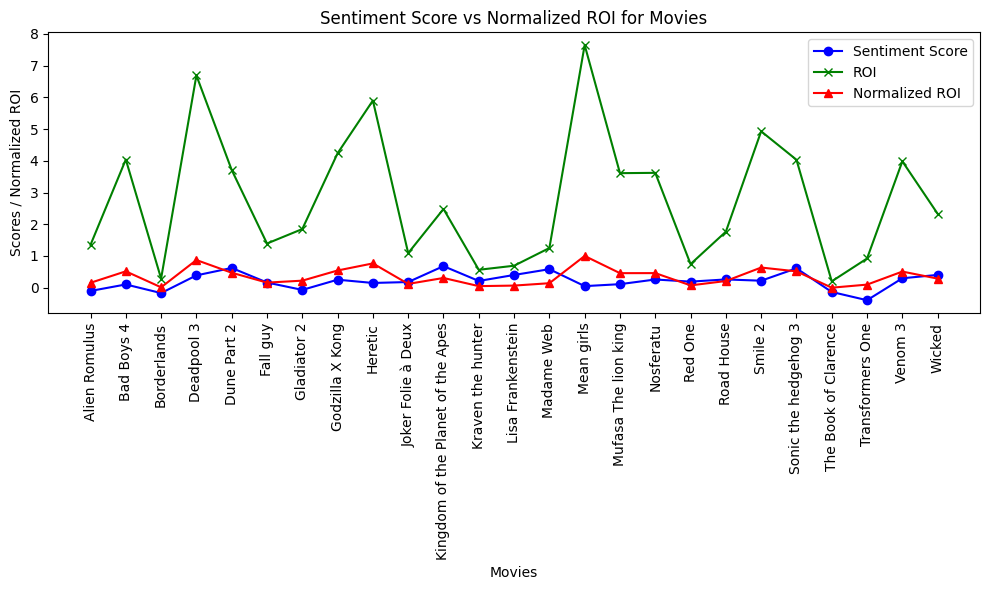

In [55]:

roi_min = min(returns)
roi_max = max(returns)
normalized_roi_min_max = [(roi - roi_min) / (roi_max - roi_min) for roi in returns]


plt.figure(figsize=(10,6))
plt.plot(movies_list, sentiment_scores, label='Sentiment Score', color='b', marker='o')
plt.plot(movies_list, returns, label='ROI', color='g', marker='x')
plt.plot(movies_list, normalized_roi_min_max, label='Normalized ROI', color='r', marker='^')


plt.xticks(rotation=90)

plt.xlabel('Movies')
plt.ylabel('Scores / Normalized ROI')
plt.title('Sentiment Score vs Normalized ROI for Movies')


plt.legend()
plt.tight_layout()
plt.show()

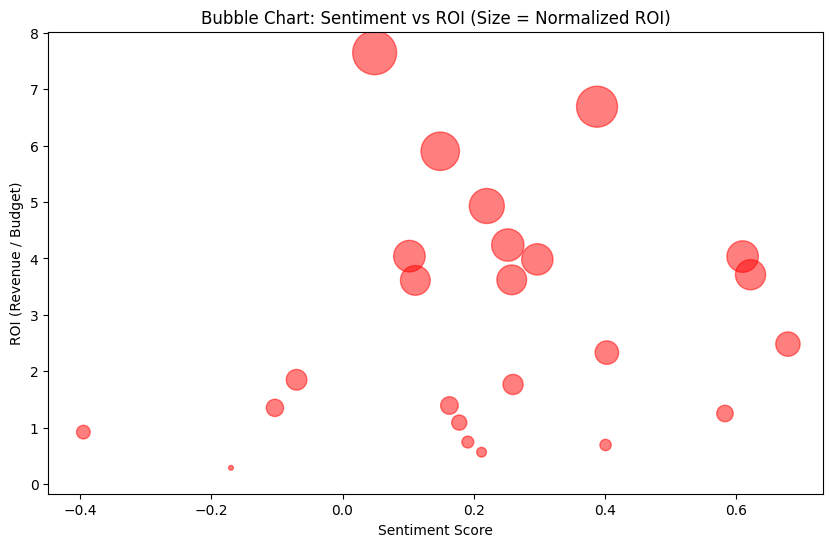

In [56]:
plt.figure(figsize=(10,6))

# Plotting Bubble chart (Sentiment vs ROI with bubble size as Normalized ROI)
plt.scatter(sentiment_scores, returns, s=np.array(normalized_roi_min_max)*1000, alpha=0.5, c='red', marker='o')

# Labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('ROI (Revenue / Budget)')
plt.title('Bubble Chart: Sentiment vs ROI (Size = Normalized ROI)')

plt.show()


In [60]:
data = pd.DataFrame({
    'ROI': returns,
    'Sentiment': sentiment_scores
})

# Calculate the correlation coefficient between ROI and sentiment
correlation = data['ROI'].corr(data['Sentiment'])
print(f"Correlation between ROI and Sentiment Scores: {correlation:.3f}")

Correlation between ROI and Sentiment Scores: 0.382


In [ ]:


# Calculate Pearson correlation coefficient
correlation = np.corrcoef(sentiment_scores, returns)[0, 1]

print(f"Correlation coefficient: {correlation:.4f}")
print(f"\nInterpretation:")
if abs(correlation) < 0.3:
    print("Weak correlation")
elif abs(correlation) < 0.7:
    print("Moderate correlation")
else:
    print("Strong correlation")

if correlation > 0:
    print("Positive relationship: as sentiment increases, returns tend to increase")
else:
    print("Negative relationship: as sentiment increases, returns tend to decrease")

Correlation coefficient: 0.2431

Interpretation:
Weak correlation
Positive relationship: as sentiment increases, returns tend to increase
